In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna
sda

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv" 
df = pd.read_csv(file_path)
# Target processing
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Binning the target
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Features and target
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill and scale
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=150, random_state=42), max_features=100)
X_selected = selector.fit_transform(X_scaled, y)

# Split and balance
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define the objective function for Optuna
def objective(trial):
    # Random Forest parameters
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 20)
    
    # XGBoost parameters
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    xgb_learning_rate = trial.suggest_loguniform('xgb_learning_rate', 1e-3, 1.0)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
    
    # Logistic Regression parameters
    lr_C = trial.suggest_loguniform('lr_C', 1e-5, 1e5)
    
    # SVM parameters
    svm_C = trial.suggest_loguniform('svm_C', 1e-5, 1e5)
    svm_gamma = trial.suggest_loguniform('svm_gamma', 1e-5, 1e5)
    
    # Define base models with optimized parameters
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, random_state=42)
    xgb_clf = xgb.XGBClassifier(n_estimators=xgb_n_estimators, learning_rate=xgb_learning_rate, max_depth=xgb_max_depth, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    log_reg = LogisticRegression(C=lr_C, max_iter=1000)
    svm_clf = SVC(C=svm_C, gamma=svm_gamma, probability=True, kernel="rbf")
    
    # Voting Classifier (soft voting)
    ensemble_model = VotingClassifier(
        estimators=[
            ("RandomForest", rf_clf),
            ("XGBoost", xgb_clf),
            ("LogReg", log_reg),
            ("SVM", svm_clf)
        ],
        voting="soft"
    )
    
    # Train and evaluate the model
    ensemble_model.fit(X_train, y_train)
    y_pred = ensemble_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# Train the final model with the best parameters
rf_clf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'], random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=best_params['xgb_n_estimators'], learning_rate=best_params['xgb_learning_rate'], max_depth=best_params['xgb_max_depth'], random_state=42, use_label_encoder=False, eval_metric='mlogloss')
log_reg = LogisticRegression(C=best_params['lr_C'], max_iter=1000)
svm_clf = SVC(C=best_params['svm_C'], gamma=best_params['svm_gamma'], probability=True, kernel="rbf")

final_ensemble_model = VotingClassifier(
    estimators=[
        ("RandomForest", rf_clf),
        ("XGBoost", xgb_clf),
        ("LogReg", log_reg),
        ("SVM", svm_clf)
    ],
    voting="soft"
)

# Train the final model
final_ensemble_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nFinal Ensemble (Voting) Accuracy: {accuracy:.2f}")
print("Final Classification Report:\n", report)


NameError: name 'sda' is not defined

[I 2025-04-09 13:47:52,267] Trial 99 finished with value: 0.49612403100775193 and parameters: {'rf_n_estimators': 101, 'rf_max_depth': 9, 'xgb_n_estimators': 208, 'xgb_learning_rate': 0.004688940345375557, 'xgb_max_depth': 3, 'lr_C': 345.7365252748685, 'svm_C': 0.01553230704118733, 'svm_gamma': 0.021450460013432517}. Best is trial 62 with value: 0.6046511627906976.
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
Best parameters: {'rf_n_estimators': 116, 'rf_max_depth': 8, 'xgb_n_estimators': 185, 'xgb_learning_rate': 0.05270132730952417, 'xgb_max_depth': 4, 'lr_C': 0.006257146650882458, 'svm_C': 0.005356681592000116, 'svm_gamma': 6.674171740334287e-05}
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Target processing
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Binning the target
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Features and target
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill and scale
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=150, random_state=42), max_features=100)
X_selected = selector.fit_transform(X_scaled, y)

# Split and balance
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Final model with best hyperparameters from Optuna
rf_clf = RandomForestClassifier(
    n_estimators=116,
    max_depth=8,
    random_state=42
)

xgb_clf = xgb.XGBClassifier(
    n_estimators=185,
    learning_rate=0.05270132730952417,
    max_depth=4,
    random_state=42,
    eval_metric='mlogloss'
)

log_reg = LogisticRegression(
    C=0.006257146650882458,
    max_iter=1000
)

svm_clf = SVC(
    C=0.005356681592000116,
    gamma=6.674171740334287e-05,
    probability=True,
    kernel="rbf"
)

final_ensemble_model = VotingClassifier(
    estimators=[
        ("RandomForest", rf_clf),
        ("XGBoost", xgb_clf),
        ("LogReg", log_reg),
        ("SVM", svm_clf)
    ],
    voting="soft"
)

# Train the final model
final_ensemble_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nFinal Ensemble (Voting) Accuracy: {accuracy:.2f}")
print("Final Classification Report:\n", report)


C:\Users\asp61\AppData\Local\Temp\ipykernel_5648\3283511954.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\subprocess.py


Final Ensemble (Voting) Accuracy: 0.60
Final Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.79      0.69        43
           1       0.48      0.38      0.43        42
           2       0.66      0.61      0.64        44

    accuracy                           0.60       129
   macro avg       0.59      0.60      0.59       129
weighted avg       0.59      0.60      0.59       129



In [3]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.2f}")

Balanced Accuracy: 0.60


In [4]:
from lifelines.utils import concordance_index

# Predict probabilities
y_proba = final_ensemble_model.predict_proba(X_test)

# Weighted average class label (0, 1, 2) used as risk score, inverted so lower value = higher risk
risk_score = -np.dot(y_proba, [0, 1, 2])
X_train, X_test, y_train, y_test, y_days_train, y_days_test = train_test_split(
    X_selected, y, y_days, test_size=0.2, random_state=42, stratify=y
)

# Concordance Index using actual survival times
c_index = concordance_index(y_days_test, risk_score)
print(f"Concordance Index (C-index): {1-c_index:.2f}")


NameError: name 'y_days' is not defined

PermutationExplainer explainer: 130it [04:02,  1.91s/it]                         
C:\Users\asp61\AppData\Local\Temp\ipykernel_6808\688511870.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns)


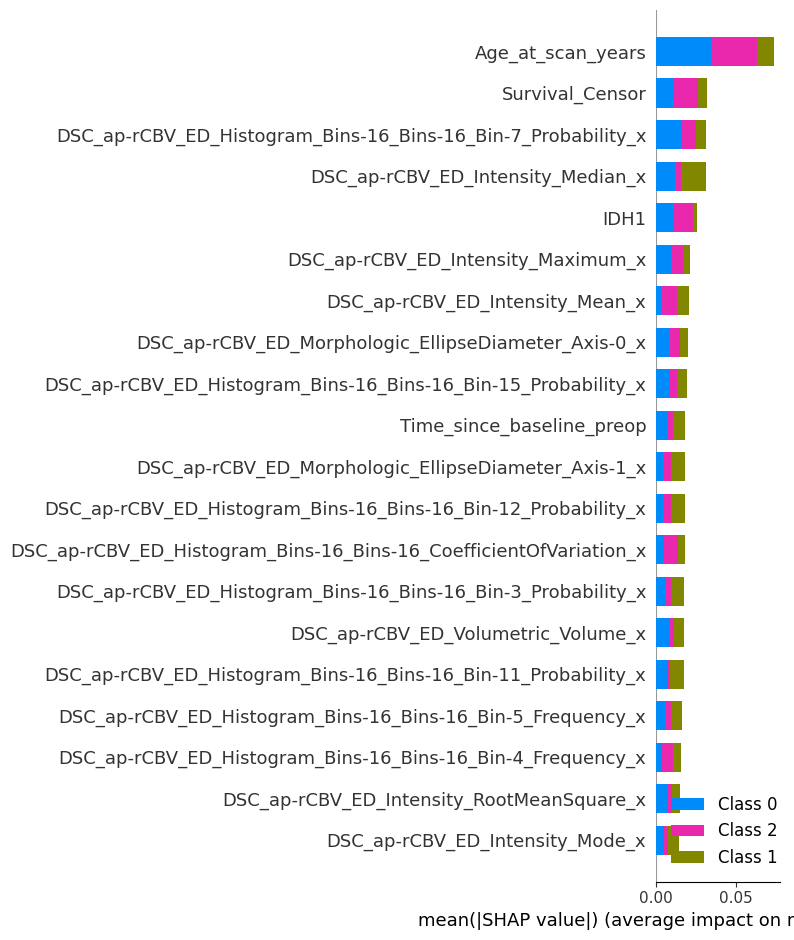

In [5]:
import shap
explainer = shap.Explainer(final_ensemble_model.predict_proba, X_test, algorithm="permutation")
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


C:\Users\asp61\AppData\Local\Temp\ipykernel_6808\3543855357.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X.columns)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour 

<Figure size 640x480 with 0 Axes>

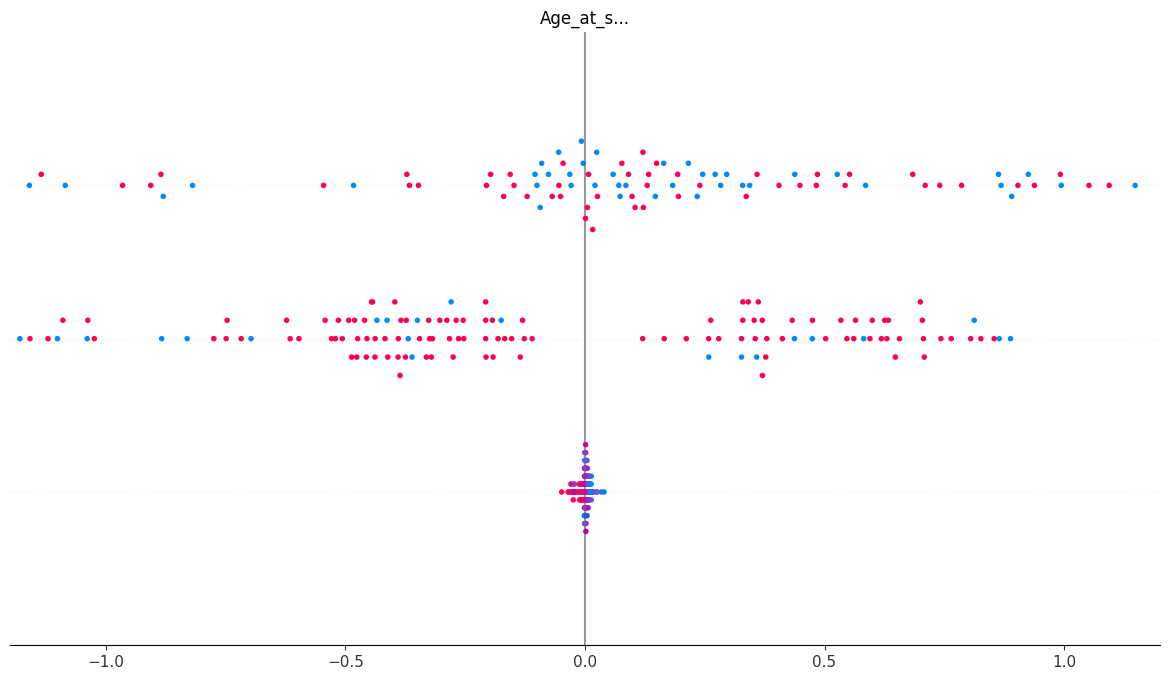

In [6]:
import shap

xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# Beeswarm plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
